# Exploring Shastry-Sutherland model with symmetric RBM (similar machine as in Science 2017)

In [220]:
import netket as nk
import numpy as np
import time
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import jax
import flax
import pprint
print("NetKet version: {}".format(nk.__version__))
print("NumPy version: {}".format(np.__version__))

NetKet version: 3.1.2
NumPy version: 1.20.3


Setup relevant parameters

In [221]:
"""lattice"""
SITES    = 20            # 4, 8, 16, 20 ... number of vertices in a tile determines the tile shape 
JEXCH1   = .2           # nn interaction
JEXCH2   = 1            # nnn interaction
#USE_MSR  = True        # should we use a Marshall sign rule?
"""machine learning"""
TOTAL_SZ = None         # 0, None ... restriction of Hilbert space
DTYPE = np.complex128   # type of weights in neural network
SAMPLER = 'local'       # 'local' = MetropolisLocal, 'exchange' = MetropolisExchange
ALPHA = 16              # N_hidden / N_visible
ETA   = .01             # learning rate (0.01 usually works)
SAMPLES = 1200
NUM_ITER = 500

OUT_NAME = "SS-RBM_ops"+str(SITES)+"j1="+str(JEXCH1) # output file name

Lattice and hamiltonian definition: &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $ H = J_{1} \sum_{\langle i,j \rangle}^{L} \vec{\sigma}_{i} \cdot \vec{\sigma}_{j} + J_{2} \sum_{\langle\langle i,j \rangle\rangle_{SS}}^{L}  \vec{\sigma}_{i} \cdot \vec{\sigma}_{j}\,, $

In [222]:
if SITES == 64:
    indent = [0,0,0,0,0,0,0,0]
    width = [8,8,8,8,8,8,8,8]
    right_shift = 0
    bottom_shift = 0
elif SITES == 36:
    indent = [0,0,0,0,0,0]
    width = [6,6,6,6,6,6]
    right_shift = 0
    bottom_shift = 0
elif SITES == 20: #tile shape definition
    indent = [3,1,0,1,1,2]
    width = [1,4,5,5,4,1]
    right_shift = 2 #vertical shift of the center of (top) right tile (in the upward direction)
    bottom_shift = 4 #horizontal shift of the center of bottom (left) tile (in the left direction)
elif SITES == 16:
    indent = [0,0,0,0]
    width = [4,4,4,4]
    right_shift = 0
    bottom_shift = 0
elif SITES == 8:
    indent = [1,0,1]
    width = [2,4,2]
    right_shift = 2
    bottom_shift = 2
elif SITES == 4:
    indent = [0,0]
    width = [2,2]
    right_shift = 0
    bottom_shift = 0
else:
    raise Exception("Invalid number of sites given.")
N = sum(width) #number of nodes

deg45 = True # special case when angle of tiling is 45 deg
i = 0
while deg45 and i < len(width)-1:
    deg45 = (width[i] == width[i+1] + 2 or width[i] == width[i+1] - 2)
    i += 1
vertical_gap = False # is there a 1-site-sized gap between bottom (left) tile and left (top) tile ? 
horizontal_gap = False # is there a 1-site-sized gap between bottom (left) tile and bottom right tile ?
if deg45:
    if width[i]%2 == 0:
        vertical_gap = True
    else:
        horizontal_gap = True
        Exception("Not implemented ERROR during lattice definition. Please rotate given lattice by 90 degrees. This special case happens only when dealing with 45 deg tilings.")

left_shift = len(width) - right_shift + vertical_gap #vertical shift of the center of (top) left tile (in the upward direction)


# i j-->
# | .   .   .   0  
# V .   1   2   3   4
#   5   6   7   8   9
#   .   10  11  12  13  14
#   .   15  16  17  18
#   .   .   19

def getRandomNumber(): #returns a random integer
    return 4
def position(node): #returns positional indices i,j of the node
    row, n = 0, 0
    while n+width[row] <= node:
        n += width[row]
        row += 1
    column = indent[row] + node - n 
    return row, column
def index_n(row, column): #returns index n given positional indices
    return sum(width[0:row]) + column - indent[row]
def is_last(node):
    row, column = position(node)
    return (column == width[row] + indent[row] - 1)
def is_first(node):
    row, column = position(node)
    return (column == indent[row])
def is_lowest(node):
    row, column = position(node)
    if row == len(width) - 1:
        return True
    else:
        row += 1
        if column >= indent[row] and column < indent[row] + width[row]:
            return False
        else:
            return True
def rt(node): #returns index n of right neighbour
    if is_last(node):
        new_row = (position(node)[0] + right_shift)%(len(width)+vertical_gap)
        if new_row == len(width): # special case of gap
            new_row -= right_shift
        return sum(width[0:new_row])
    else:
        return (node+1)%N
def lft(node): #returns index n of left neighbour
    if is_first(node):
        new_row = (position(node)[0] + left_shift)%(len(width)+vertical_gap)
        if new_row == len(width):
            new_row -= left_shift
        return sum(width[0:new_row])+width[new_row]-1
    else:
        return (node-1)%N
def bot(node): #returns index n of bottom neighbour
    row, column = position(node)
    if is_lowest(node):
        no_of_columns = np.array(width)+np.array(indent)
        new_column = (column + bottom_shift)%max(no_of_columns)
        new_row = 0
        while new_column >= no_of_columns[new_row] or new_column < indent[new_row]:
            new_row += 1
        return index_n(new_row,new_column)
    else:
        return (node + width[row] + indent[row] - indent[row+1])
def lrt(node):
    return rt(bot(node))
def llft(node):
    return lft(bot(node))
#def dimer_partner(node): #retunrs the index of the site which has J_2 bond with given node (partner in always unique in SS model)
#    row, column = position(node)
#    return TODO

# Define custom graph
edge_colors = []
for node in range(N):
    edge_colors.append([node,rt(node), 1]) #horizontal connections
    edge_colors.append([node,bot(node), 1]) #vertical connections
    row, column = position(node)
    if column%2 == 0:
        if row%2 == 0:
            edge_colors.append([node,lrt(node),2])
        else:
            edge_colors.append([node,llft(node),2])


# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

hilbert = nk.hilbert.Spin(s=.5, N=g.n_nodes, total_sz=TOTAL_SZ)


#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz)) #=sz*sz
#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]]) #=sx*sx+sy*sy = 1/2*(sp*sm+sm*sp)
full_spin = mszsz+exchange # = S*S = sx*sx + sy*sy + sz*sz
bond_color = [1, 2, 1, 2]

In [223]:
print(len(g.automorphisms()))

1


## Hamoltonian

In [176]:
bond_operator = [
    (JEXCH1 * mszsz).tolist(),
    (JEXCH2 * mszsz).tolist(),
    (JEXCH1 * exchange).tolist(), # minus in case of MSR
    (JEXCH2 * exchange).tolist(),
]
bond_operatorMSR = [
    (JEXCH1 * mszsz).tolist(),
    (JEXCH2 * mszsz).tolist(),
    (-JEXCH1 * exchange).tolist(), # minus in case of MSR
    (JEXCH2 * exchange).tolist(),
]
ha = nk.operator.GraphOperator(hilbert, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)
ha_MSR = nk.operator.GraphOperator(hilbert, graph=g, bond_ops=bond_operatorMSR, bond_ops_colors=bond_color)


## Exact diagonalization

In [177]:
if g.n_nodes < 21:
    start = time.time()
    evals, eigvects = nk.exact.lanczos_ed(ha, k=3, compute_eigenvectors=True)
    #evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False) #.lanczos_ed
    end = time.time()
    diag_time = end - start
    exact_ground_energy = evals[0]
    print("Ground state energy:",exact_ground_energy, "\nIt took ", round(diag_time,2), "s =", round((diag_time)/60,2),"min")
else:
    print("System is too large for exact diagonalization. Setting exact_ground_energy = 0 (which is wrong)")
    exact_ground_energy = [0,0,0]
    eigvects = None 
# -36.2460684609957 

Ground state energy: -12.00000000000001 
It took  0.0 s = 0.0 min


## Zkouška implementace parametru uspořádání

## RBM

!!POZOZ je použito `g.automorphisms()` namísto `g.translations()` - obsahuje to tedy symetrii zrcadlení řetízku navíc, a proto na konci dostaneme jen dvě sady filtrů namísto čtyřech.

Vskutku, metoga g.automorphisms() najde veškeré symetrie. V tomto případě jsou všechny složeny z nezávislých symetrií:
<!-- ### Heisenberg
 * zrcadlení okolo $x$, 
 * zdcadlení okolo $y$, 
 * jedna rotace o $90$ stupňů (ostatní se dají složit se zrcadleními),
 * ``L_NUM*L_NUM`` translací,

tedy celkem $8L_{NUM}^2$ (pro $L_{NUM} > 2$, protože pro $L_{NUM}=2$ je zrcadlení a translace ekvivalentní) -->

### Shastry-Sutherland 
 * ``L_NUM*L_NUM`` translací,
 * rotace o $90$ stupňů,

tedy celkem $4L_{NUM}^2$ (stejně je vždy $L_{NUM} \geq 4$)

```
#comment from github: Have you tried using g.translation_group() (or g.translations() is some of the previous beta versions)
 instead of .automorphisms() to check whether that makes a difference? (Using the larger group of all 6x6 space group symmetries 
 is probably also the reason why a large alpha is required in your version.) While symmetries should make a state easier to learn,
 I do recall that using the full space or automorphism group (instead of the usually easier-to-handle translation group) can 
 sometimes introduce convergence issues (which at least need some more careful tuning of optimization settings and probably 
 initial params to overcome).
#https://github.com/netket/netket/discussions/838
```

In [178]:
#definice modelu, sampleru atd.

# Symmetric RBM Spin Machine
machine = nk.models.RBMSymm(g.automorphisms(),dtype=DTYPE, alpha=ALPHA)  #<--- zde je použita celá grupa symetrii (ne jen translace)
print("Number of automorphisms:", len(g.automorphisms()))
# Symmetric RBM Spin Machine with MSR
machine_MSR = nk.models.RBMSymm(g.automorphisms(),dtype=DTYPE, alpha=ALPHA)


# Meropolis Exchange Sampling
if SAMPLER == 'local':
    sampler = nk.sampler.MetropolisLocal(hilbert=hilbert)
    sampler_MSR = nk.sampler.MetropolisLocal(hilbert=hilbert)
else:
    sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=g)
    sampler_MSR = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=g)
    if SAMPLER != 'exchange':
        print("Warning! Undefined sampler:", SAMPLER, ", dafaulting to MetropolisExchange sampler")


# Optimzer
optimizer = nk.optimizer.Sgd(learning_rate=ETA)
optimizer_MSR = nk.optimizer.Sgd(learning_rate=ETA)

# Stochastic Reconfiguration
sr  = nk.optimizer.SR(diag_shift=0.1)
sr_MSR  = nk.optimizer.SR(diag_shift=0.1)

# The variational state (drive to byla nk.variational.MCState)
vss = nk.vqs.MCState(sampler, machine, n_samples=SAMPLES)
vs_MSR  = nk.vqs.MCState(sampler_MSR, machine_MSR, n_samples=SAMPLES)
vss.init_parameters(jax.nn.initializers.normal(stddev=0.001))
vs_MSR.init_parameters(jax.nn.initializers.normal(stddev=0.001))


gs_normal = nk.VMC(hamiltonian=ha ,optimizer=optimizer,preconditioner=sr,variational_state=vss)               # 0 ... symmetric
gs_MSR = nk.VMC(hamiltonian=ha_MSR ,optimizer=optimizer_MSR,preconditioner=sr_MSR,variational_state=vs_MSR)   # 1 ... symmetric+MSR

Number of automorphisms: 128


# Definitions of operators

In [179]:
def SS_old(i,j): # S_i * S_j
    return 2*nk.operator.spin.sigmap(hilbert,i,dtype="float64")@nk.operator.spin.sigmam(hilbert,j,dtype="float64")+2*nk.operator.spin.sigmam(hilbert,i,dtype="float64")@nk.operator.spin.sigmap(hilbert,j,dtype="float64")+nk.operator.spin.sigmaz(hilbert,i,dtype="float64")@nk.operator.spin.sigmaz(hilbert,j,dtype="float64")
    #return nk.operator.spin.sigmax(hilbert, i)@nk.operator.spin.sigmax(hilbert, j) + nk.operator.spin.sigmay(hilbert, i)@nk.operator.spin.sigmay(hilbert, j) + nk.operator.spin.sigmaz(hilbert, i)@nk.operator.spin.sigmaz(hilbert, j)

def SS(i,j): #different method of definition
    if i==j:
        return nk.operator.LocalOperator(hilbert,operators=[[3,0],[0,3]],acting_on=[i])
    else:
        return nk.operator.LocalOperator(hilbert,operators=(mszsz+exchange),acting_on=[i,j])

def SS_MSR(i,j): #different method of definition
    if i==j:
        return nk.operator.LocalOperator(hilbert,operators=[[3,0],[0,3]],acting_on=[i])
    elif (np.sum(position(i))+np.sum(position(j)))%2 == 0:                                      # same sublattice 
        return nk.operator.LocalOperator(hilbert,operators=(mszsz+exchange),acting_on=[i,j])
    else:                                                                                       # different sublattice 
        return nk.operator.LocalOperator(hilbert,operators=(mszsz-exchange),acting_on=[i,j])

## Dimer order parameter (DS phase)
$$m_{\rm dimer}^2 := -\frac{1}{3} \frac{2}{M} \sum_{(ij)_{dimer}} \langle\hat{\bm{S}}_i \cdot \hat{\bm{S}}_j\rangle$$
plus normalizace na 3/4 (v mém případě 3)

In [180]:
ss_operator = 0
M = hilbert.size
for node in range(M):
    row, column = position(node)
    if column%2 == 0:
        if row%2 == 0:
            ss_operator += SS(node,lrt(node))
        else:
            ss_operator += SS(node,llft(node))
m_dimer_op = -1/3 * ss_operator/M*2

## Plaquette order parameter (PS phase)
We define another order parameter $m_p := \langle \hat{\bm{Q}}_{\bm{R}} - \hat{\bm{Q}}_{\bm{R'}}\rangle$, where $\hat{\bm{Q}}_{\bm{r}} := \frac{1}{2}\left(\hat{\bm{P}}_{\bm{r}} + \hat{\bm{P}}_{\bm{r}}^{-1}\right)$, where $\hat{\bm{P}}_{\bm{r}} = \hat{\bm{P}}_{ijkl}^\text{cykl}$ is cyclic permutation operator 
$$\hat{\bm{P}}_{ijkl}^\text{cykl} | \dots \sigma_i \sigma_j \sigma_k \sigma_l \dots \rangle = | \dots \sigma_l \sigma_i \sigma_j \sigma_k \dots \rangle $$
We can implement cyclic permutation using binary permutation operator
$$ \hat{\bm{P}}^\text{cykl}_{ijkl} = \hat{\bm{P}}_{ik}\hat{\bm{P}}_{kl}\hat{\bm{P}}_{ij} \quad \quad \quad \left(\hat{\bm{P}}^\text{cykl}_{ijkl}\right)^{-1} = \hat{\bm{P}}_{jl}\hat{\bm{P}}_{kl}\hat{\bm{P}}_{ij}$$
And use a formula for permutation operator
$$ \hat{\bm{P}}_{ij} \equiv \frac{1}{2} (\hat{\bm{S}}_i\cdot \hat{\bm{S}}_j + \hat{\mathbb{1}})$$

In [181]:
def P(i,j,msr): # two particle permutation operator
    if msr == False:
        return .5*(SS(i,j)+nk.operator.LocalOperator(hilbert,operators=[[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],acting_on=[i,j]))
    else:
        return .5*(SS_MSR(i,j)+nk.operator.LocalOperator(hilbert,operators=[[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],acting_on=[i,j]))


def P_cykl(i,j,k,l,msr): # 4 particle cyclic permutation operator
    return P(i,k,msr)@P(k,l,msr)@P(i,j,msr)
def P_cykl_inv(i,j,k,l,msr): # inverse of 4 particle cyclic permutation operator
    return P(j,l,msr)@P(k,l,msr)@P(i,j,msr)

def P_r(i,msr): # cyclic permutation of 4 sites located at position i
    return P_cykl(i,rt(i),lrt(i),bot(i),msr)
# i --> i j  .... we assigne a lrt cell to each index i
#       l k
def P_r_inv(i,msr): # inverse of cyclic permutation of 4 sites located at position i
    return P_cykl_inv(i,rt(i),lrt(i),bot(i),msr)

def Q_r(i,msr):
    return .5*(P_r(i,msr) + P_r_inv(i,msr))

i = 0
while sum(position(i))%2 == 0: # ensure that the plaquette is 'empty' (without J_2 bond inside)
    i += 1
m_plaquette_op = Q_r(i,False)-Q_r(lrt(i),False)
m_plaquette_op_MSR = Q_r(i,True)-Q_r(lrt(i),True)

## Magnetization order parameter (AF phase)
We define magnetization order parameter <font color=#d0312d> POZOR! můj spin $\hat{\bm{S}}$ je definovaný jako dvojnásobek typické definice $\hat{\bm{S}} \leftarrow 2\hat{\bm{S}}$ </font>
$$m_s^2 := \frac{1}{M^{2}} \sum_{ij} {\rm e}^{i \bm{q}\cdot \bm{r}} \langle\hat{\bm{S}}_i \cdot \hat{\bm{S}}_j\rangle$$
where $M = L\cdot L$ (in case of Sandvik: $M = 2L\cdot L$ and $\hat{\bm{S}} = \frac{1}{2}\hat{\bm{S}}$). In our case $\bm{q} = (\pi,\pi)$.

Využíváme také identitu $\sigma^x_i\sigma^x_j+\sigma^y_i\sigma^y_j \equiv {2}\left(\sigma^+_i\sigma^-_j + \sigma^-_i\sigma^+_j\right)$


In [182]:
def m_sSquared_slow(state):
    ss_operator = 0
    M = hilbert.size
    m_s2 = 0
    for i in range(M):
        for j in range(M):
            ss_operator += SS(i,j) * (-1)**np.sum(position(i)+position(j))
        if i%3==2 or i==(M-1):
            m_s2 += (state.transpose()@(ss_operator@state))[0,0]
            ss_operator = 0
    m_s2 = m_s2/M**2
    return m_s2

m_s2_op_MSR = 0
M = hilbert.size
for i in range(M):
    for j in range(M):
        m_s2_op_MSR += SS_MSR(i,j) * (-1)**np.sum(position(i)+position(j)) #(i+j) #chyba?
m_s2_op_MSR = m_s2_op_MSR/(M**2)

m_s2_op = 0
for i in range(M):
    for j in range(M):
        m_s2_op += SS(i,j) * (-1)**np.sum(position(i)+position(j)) #(i+j) #chyba?
m_s2_op = m_s2_op/(M**2)


## calculation

In [183]:
no_of_runs = 2 #2 ... bude se pocitat i druhý způsob (za použití MSR)
use_MSR = 0 # in case of one run
NUM_ITER = 500
print("J_1 =", JEXCH1)
if exact_ground_energy != 0:
    print("Expected exact energy:", exact_ground_energy)
for i,gs in enumerate([gs_normal,gs_MSR][use_MSR:use_MSR+no_of_runs]):
    start = time.time()
    #gs.info()
    gs.run(out=OUT_NAME+str(i), n_iter=int(NUM_ITER))#,obs={'DS_factor': m_dimer_op})#,'PS_factor':m_plaquette_op,'AF_factor':m_s2_op})
    end = time.time()
    print("The type {} of RBM calculation took {} min".format(i, (end-start)/60))


J_1 = 0.2
Expected exact energy: -12.00000000000001


100%|██████████| 500/500 [02:17<00:00,  3.63it/s, Energy=-0.7956+0.0042j ± 0.0019 [σ²=0.0022, R̂=1.4095]]


The type 0 of RBM calculation took 2.4027594486872355 min


100%|██████████| 500/500 [02:24<00:00,  3.46it/s, Energy=-0.8418+0.0000j ± 0.0052 [σ²=0.0163, R̂=1.3721]]

The type 1 of RBM calculation took 2.4136064370473225 min


In [184]:
print(gs_MSR.energy.mean.real)

-0.841835478129867


In [185]:
for i,gs in enumerate([gs_normal,gs_MSR][use_MSR:use_MSR+no_of_runs]):
    print("Trained RBM with MSR:" if i else "Trained RBM without MSR:")
    print("m_d^2 =", gs.estimate(m_dimer_op))
    print("m_p =", gs.estimate(m_plaquette_op_MSR))
    print("m_s^2 =", gs.estimate(m_s2_op_MSR))
    print("m_s^2 =", gs.estimate(m_s2_op), "<--- no MSR!!")

Trained RBM without MSR:
m_d^2 = -3.333e-01-2.191e-16j ± 2.080e-17 [σ²=2.952e-31, R̂=1.3348]
m_p = -0.155-0.002j ± 0.035 [σ²=0.753, R̂=1.2293]
m_s^2 = 0.605+0.000j ± 0.017 [σ²=0.166, R̂=1.4068]
m_s^2 = 1.49914-0.00059j ± 0.00031 [σ²=0.00006, R̂=1.3835] <--- no MSR!!
Trained RBM with MSR:
m_d^2 = -3.333e-01-2.688e-18j ± 5.108e-18 [σ²=1.405e-32, R̂=1.4108]
m_p = -0.143+0.000j ± 0.040 [σ²=0.935, R̂=1.3664]
m_s^2 = 1.49880-0.00000j ± 0.00089 [σ²=0.00050, R̂=1.2824]
m_s^2 = 0.617+0.000j ± 0.017 [σ²=0.165, R̂=1.3828] <--- no MSR!!


In [186]:
print(gs_normal.energy.mean.real, gs_MSR.energy.mean.real, gs_normal.estimate(m_dimer_op).mean.real, gs_normal.estimate(m_plaquette_op).mean.real, gs_normal.estimate(m_s2_op_MSR).mean.real, gs_normal.estimate(m_s2_op).mean.real, gs_MSR.estimate(m_dimer_op).mean.real, gs_MSR.estimate(m_plaquette_op).mean.real, gs_MSR.estimate(m_s2_op_MSR).mean.real, gs_MSR.estimate(m_s2_op).mean.real, sep='    ')

-0.7956492821794932    -0.841835478129867    -0.3333333333333337    -0.20967005255676013    0.6049722288191763    1.4991379362190331    -0.33333333333333326    -0.0319599045554229    1.4987986065807426    0.6173100090062216


In [187]:
print("{:f}     {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    {:f}    samples:{:f}  iters:{:f}".format(gs_normal.energy.mean.real, gs_MSR.energy.mean.real, gs_normal.estimate(m_dimer_op).mean.real, gs_normal.estimate(m_plaquette_op).mean.real, gs_normal.estimate(m_s2_op_MSR).mean.real, gs_normal.estimate(m_s2_op).mean.real, gs_MSR.estimate(m_dimer_op).mean.real, gs_MSR.estimate(m_plaquette_op_MSR).mean.real, gs_MSR.estimate(m_s2_op_MSR).mean.real, gs_MSR.estimate(m_s2_op).mean.real, SAMPLES, NUM_ITER, sep='    '))

-0.795649     -0.841835    -0.333333    -0.209670    0.604972    1.499138    -0.333333    -0.143040    1.498799    0.617310    samples:1200.000000  iters:500.000000


## Energy

In [188]:
# exact energy line
figure = go.Figure(
    data=[go.Scatter(x=(0,NUM_ITER),y=(exact_ground_energy,exact_ground_energy),mode="lines",line=go.scatter.Line(color="#000000",width=1), name="exact energy")], 
    layout=go.Layout(template="simple_white",
        xaxis=dict(title="Iteration", mirror=True, showline=True),
        yaxis=dict(title="Energy", mirror=True, showline=True),
        title=("<b>"+"S-S"+" model </b>, L="+str(SITES)+", J2 ="+str(JEXCH2)+ " , η="+str(ETA)+", α="+str(ALPHA)+", samples="+str(SAMPLES))))

In [189]:
# import the data from log file
OUT_NAME_suffixless=OUT_NAME
data = []
for i in range(no_of_runs):
    data.append(json.load(open(OUT_NAME_suffixless+str(i)+".log")))
names = ["normal basis","MSR basis"]
if DTYPE==np.complex128:
    energy_convergence = [data[i]["Energy"]["Mean"]["real"] for i in range(no_of_runs)]
    # DS_factor_convergence = [data[i]["DS_factor"]["Mean"]["real"] for i in range(no_of_runs)]
else:
    energy_convergence = [data[i]["Energy"]["Mean"] for i in range(no_of_runs)]
    # DS_factor_convergence = [data[i]["DS_factor"]["Mean"] for i in range(no_of_runs)]
for i in range(no_of_runs):
    figure.add_trace(go.Scatter(
        x=data[i]["Energy"]["iters"], y=energy_convergence[i],
        name=names[i]
    ))
    # figure.add_trace(go.Scatter(
    #     x=data[i]["Energy"]["iters"], y=DS_factor_convergence[i],
    #     name=names[i]+"_DS"
    # ))

#figure.add_hline(y=exact_gs_energy)
figure.update_layout(xaxis_title="Iteration",yaxis_title="Energy")
figure.show()

In [190]:
sep="   "
print(str(JEXCH1)+sep+str(JEXCH2)+sep+str(exact_ground_energy)+sep+str(energy_convergence[0][NUM_ITER-1])+sep+str(energy_convergence[1][NUM_ITER-1])+"\n")


0.2   1   -12.00000000000001   -0.7956492821794932   -0.841835478129867



## Saving to file

In [191]:
outFile = open("energies_complexRBM_N="+str(N)+".txt","a")
sep="   "
outFile.write(str(JEXCH1)+sep+str(JEXCH2)+sep+str(exact_ground_energy)+sep+str(energy_convergence[0][NUM_ITER-1])+sep+str(energy_convergence[1][NUM_ITER-1])+"\n")
outFile.close()

## Feature filters

In [192]:
# get filters for Symmetric Hamiltonian
Filters = vs_MSR.parameters["Dense"]["kernel"]

In [193]:
print(len(Filters)/g.n_nodes)
print(Filters.shape)

0.125
(1, 8)


In [194]:
#calculation of extreme points for normalization
no_of_filters = Filters.shape[0]
maximal = max([max(Filters[i]) for i in range(no_of_filters)])
minimal = min([min(Filters[i]) for i in range(no_of_filters)])
print("max:",maximal,"   min:",minimal, "    number of filters:",no_of_filters)
extreme = max(abs(maximal),abs(minimal))

max: (0.023341917030256728-0.11639290253196823j)    min: (-0.02345835441531539-0.11639806738827682j)     number of filters: 1


TypeError: 'AxesSubplot' object is not subscriptable

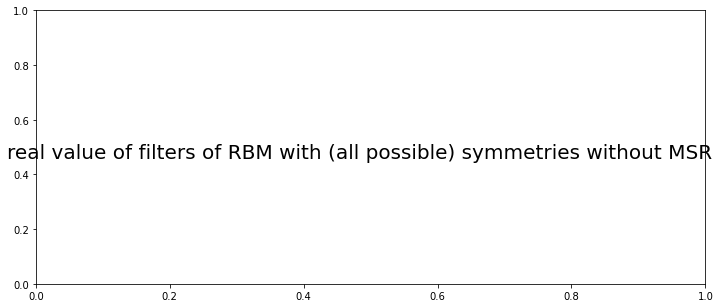

In [195]:
L_NUM = 4
fig, axs = plt.subplots(1, no_of_filters, figsize=(12,2*no_of_filters))
#fig.tight_layout(pad=.0)
fig.subplots_adjust(top=1.9,bottom=0,wspace=.4)
fig.suptitle("real value of filters of RBM with (all possible) symmetries without MSR", fontsize=20)
for a in range(no_of_filters):
    im = axs[a].imshow(np.real(Filters[a]).reshape(L_NUM,L_NUM), cmap="RdYlBu", vmin=-extreme,vmax=extreme)#,interpolation="spline16")
    axs[a].set_ylabel(r"$W^{("+str(a+1)+r")}$", rotation=None,fontsize="x-large",horizontalalignment="right",verticalalignment="center")
    axs[a].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# Now adding the colorbar
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=.4)

plt.show()